In [1]:
# Import and GPU Support
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import time

from B_data import create_residual_data, create_IC_data, initial_u,exact_u, create_BC_data, create_RH_data,create_RH_data_endt,Move_Time_1D,burgersDdt_godunov,godunov,exact_u_err
from B_Plotting import Burgers_plot, loss_plot 
from scipy.integrate import solve_ivp

# Full PINN
from B_PINN import NN
from B_PINN_train import pinn_train

# Burgers VGPT-PINN
from B_VGPT_activation import P
from B_VGPT_PINNs import GPT
from B_VGPT_train import gpt_train

torch.set_default_dtype(torch.float)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Device: {device}")
if torch.cuda.is_available():
    print(f"Current Device Name: {torch.cuda.get_device_name()}")

Current Device: cuda
Current Device Name: NVIDIA A100-SXM4-40GB


In [2]:
# Training Parameter Set
number_of_parameters = 2
nu1_training = np.linspace(0.75, 1.25, number_of_parameters)
nu2_training  = np.linspace(0.1, 0.4, number_of_parameters)

nu_training = []
for i in range(nu1_training.shape[0]):
    for j in range(nu2_training.shape[0]):
        nu_training.append([nu1_training[i],nu2_training[j]])
nu_training = np.array(nu_training)

nu_pinn_train = [1.0,0.0]
number_of_neurons = 1
P_list = np.ones(number_of_neurons, dtype=object) 

In [3]:
# Domain and Data
Xi, Xf         = 0.0, 1.0
Ti, Tf         =  0.0, 1.0
Nx_train, Nt_train =  101, 201
Nx_test, Nt_test = 101, 201
IC_pts, IC_simple = 100, 100
BC_pts =  100
N_RH = IC_pts
dx = 0.001
dt = 0.0002

residual_data = create_residual_data(Xi, Xf, Ti, Tf, Nx_train, Nt_train, Nx_test, Nt_test, dx,dt)
xt_resid      = residual_data[0].to(device)
f_hat         = residual_data[1].to(device)
xt_test       = residual_data[2].to(device)
xt_RHL      = residual_data[3].to(device)
xt_RHR      = residual_data[4].to(device)
xt_RHt         = residual_data[5].to(device)
xt_RHtL       = residual_data[6].to(device)

IC_x_test     = xt_test[0:Nx_test,:1].squeeze().cpu()
IC_t_test     = xt_test[0:Nx_test*Nt_test:Nx_test,1:].squeeze().cpu()

Nx_test0, Nt_test0 = 1001, 2001
xt_test0 = create_residual_data(Xi, Xf, Ti, Tf, Nx_train, Nt_train, Nx_test0, Nt_test0, dx,dt)[2].to(device)
IC_x_test0     = xt_test0[0:Nx_test0,:1].squeeze().cpu()
IC_t_test0     = xt_test0[0:Nx_test0*Nt_test0:Nx_test0,1:].squeeze().cpu()   

BC_data = create_BC_data(Xi, Xf, Ti, Tf, BC_pts)
BC1     = BC_data[0].to(device)
BC2     = BC_data[1].to(device)

#xt_RH_data = create_RH_data(Xi, Xf, Ti, Tf, IC_pts, N_RH,dx)
#xt_RH = xt_RH_data[0].to(device)
#xt_RHL = xt_RH_data[1].to(device)

In [4]:
# Setting PINN and TGPT-PINN
# Setting PINN and TGPT-PINN
layers_pinn = np.array([2, 30, 30, 30, 30, 30, 1])

lr_pinn     = 0.001
epochs_pinn = 60000
tol_pinn    = 1e-5

pinn_train_times = np.ones(number_of_neurons)

###############################################################################
################################ Training Loop ################################
###############################################################################

In [5]:
import pickle
P_name=f"IFNN_shock3.pkl"
with open(P_name, 'rb') as f:
    P_list = pickle.load(f)

[0.75 0.1 ] stopped at epoch: 0 | gpt_loss: 0.4352359175682068,rMAE: [0.3659288138173758], rRMSE:[0.7187126848821233], 0.025850124657154083, 0.040938567370176315, 9.566160308338567e-09, 1.2101540472833627e-12
[0.75 0.1 ] stopped at epoch: 500 | gpt_loss: 0.0007066696416586637,rMAE: 0.030696898349920756, rRMSE:0.18697914194061008, 0.00024725630646571517, 6.602436428693181e-07, 7.929303365017404e-07, 4.4488158891908824e-05
[0.75 0.1 ] stopped at epoch: 1000 | gpt_loss: 0.0007066689431667328,rMAE: 0.030696381906202008, rRMSE:0.18697681250690135, 0.0002472587220836431, 6.599865969292296e-07, 7.928743457341625e-07, 4.4488158891908824e-05
[0.75 0.1 ] stopped at epoch: 1500 | gpt_loss: 0.0007066671969369054,rMAE: 0.030695258357725953, rRMSE:0.186970240587723, 0.00024725994444452226, 6.597880428671488e-07, 7.927793035378272e-07, 4.4488158891908824e-05
[0.75 0.1 ] stopped at epoch: 2000 | gpt_loss: 0.000436964794062078,rMAE: 0.021168762332008383, rRMSE:0.10896744863149853, 0.0002825232513714581

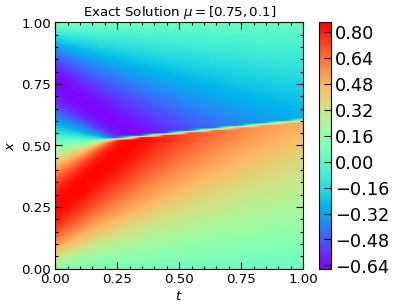

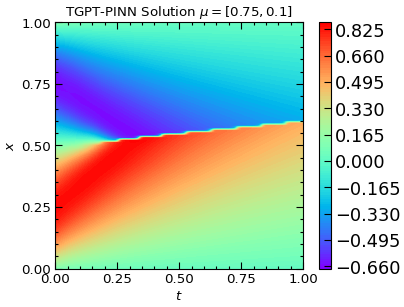

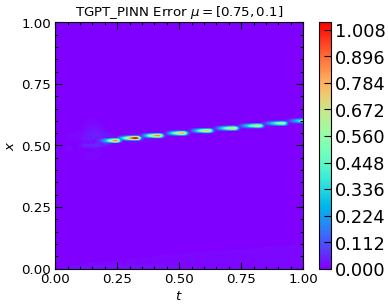

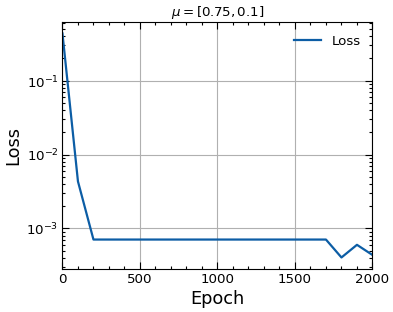

GPT-PINN at [0.75 0.1 ] with the Loss=0.000436964794062078, rMAE = 0.021168762332008383, rRMSE = 0.10896744863149853


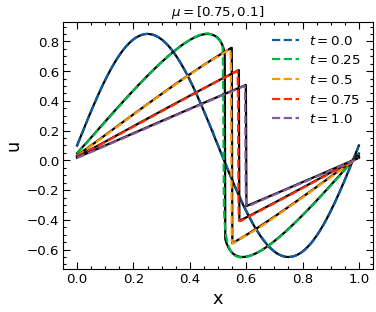

[0.75 0.4 ] stopped at epoch: 0 | gpt_loss: 2.0861382484436035,rMAE: [0.868565203218479], rRMSE:[1.1166726170899548], 0.17673885822296143, 0.19093991816043854, 9.566160308338567e-09, 1.2101540472833627e-12
[0.75 0.4 ] stopped at epoch: 500 | gpt_loss: 0.0023195191752165556,rMAE: 0.038172839249820505, rRMSE:0.16892889510418896, 0.0005021833931095898, 3.602615470299497e-05, 0.00011239456944167614, 3.331288098706864e-05
[0.75 0.4 ] stopped at epoch: 1000 | gpt_loss: 0.0023195273242890835,rMAE: 0.038173492442677204, rRMSE:0.16893120480635843, 0.000502194685395807, 3.602600554586388e-05, 0.00011239438754273579, 3.331288098706864e-05
[0.75 0.4 ] stopped at epoch: 1500 | gpt_loss: 0.002319522900506854,rMAE: 0.038172821149574744, rRMSE:0.1689288750810266, 0.0005021955003030598, 3.60260164598003e-05, 0.00011239385639782995, 3.331288098706864e-05
[0.75 0.4 ] stopped at epoch: 2000 | gpt_loss: 0.0023195038083940744,rMAE: 0.03817356764945006, rRMSE:0.16893171364695364, 0.0005021541146561503, 3.602

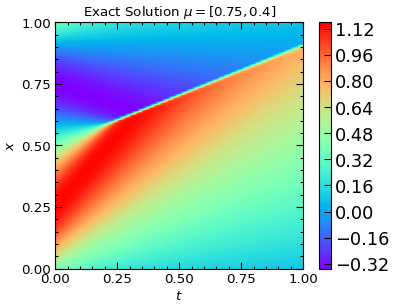

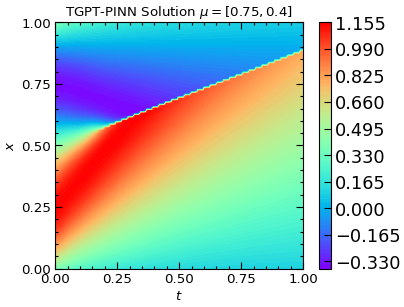

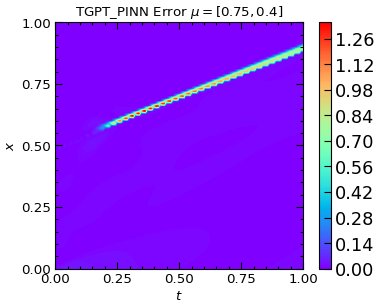

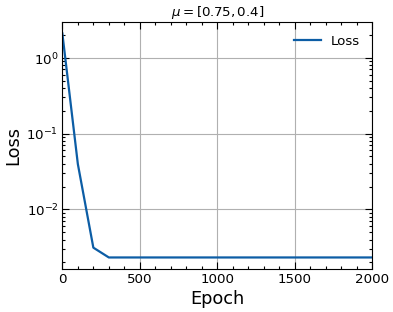

GPT-PINN at [0.75 0.4 ] with the Loss=0.0023195038083940744, rMAE = 0.03817356764945006, rRMSE = 0.16893171364695364


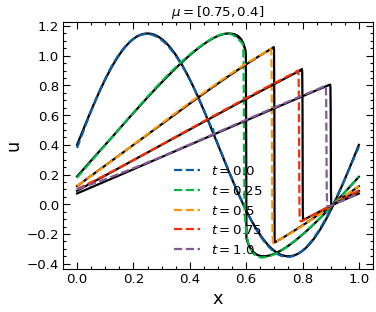

[1.25 0.1 ] stopped at epoch: 0 | gpt_loss: 0.4346519708633423,rMAE: [0.26654678874414434], rRMSE:[0.5716951786319594], 0.025277739390730858, 0.04093741253018379, 9.566160308338567e-09, 1.2101540472833627e-12
[1.25 0.1 ] stopped at epoch: 500 | gpt_loss: 0.0014917023945599794,rMAE: 0.025067768402414373, rRMSE:0.14288651838698482, 0.0011919387616217136, 1.172987367681344e-06, 1.2880598660558462e-05, 1.592277294548694e-05
[1.25 0.1 ] stopped at epoch: 1000 | gpt_loss: 0.0017241023015230894,rMAE: 0.02767631614149507, rRMSE:0.16027832984540613, 0.0010293037630617619, 4.995937160856556e-06, 1.1462678230600432e-05, 5.302123827277683e-05
[1.25 0.1 ] stopped at epoch: 1500 | gpt_loss: 0.0014512271154671907,rMAE: 0.02564005399141865, rRMSE:0.14374259048389665, 0.0011110315099358559, 3.943046976928599e-06, 1.3001214028918184e-05, 1.7075295545510016e-05
[1.25 0.1 ] stopped at epoch: 2000 | gpt_loss: 0.0012303882976993918,rMAE: 0.029513848362637277, rRMSE:0.1698312301107903, 0.0011014669435098767,

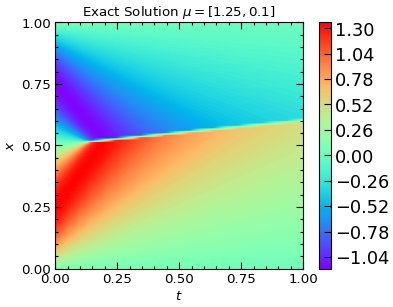

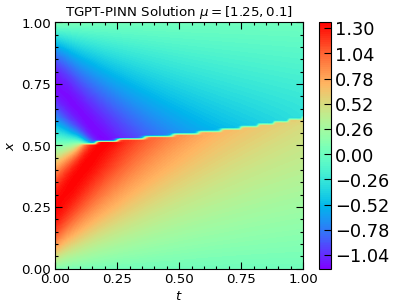

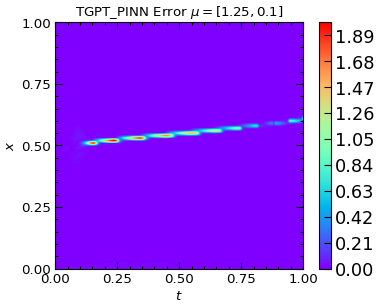

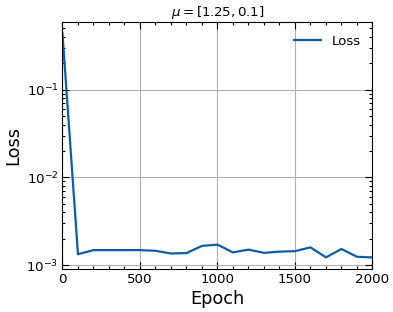

GPT-PINN at [1.25 0.1 ] with the Loss=0.0012303882976993918, rMAE = 0.029513848362637277, rRMSE = 0.1698312301107903


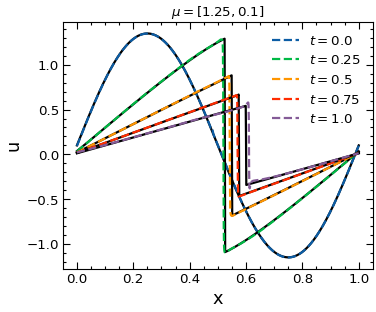

[1.25 0.4 ] stopped at epoch: 0 | gpt_loss: 2.0837979316711426,rMAE: [0.7287366685226848], rRMSE:[0.986358306419847], 0.17441034317016602, 0.19093875586986542, 9.566160308338567e-09, 1.2101540472833627e-12
[1.25 0.4 ] stopped at epoch: 500 | gpt_loss: 0.011952548287808895,rMAE: 0.05699530204468376, rRMSE:0.23337600840787778, 0.006285159382969141, 8.812388114165515e-05, 0.00043892255052924156, 3.969252429669723e-05
[1.25 0.4 ] stopped at epoch: 1000 | gpt_loss: 0.01160952728241682,rMAE: 0.05864475003066665, rRMSE:0.23767777481430005, 0.005987166427075863, 8.701277693035081e-05, 0.0004435447044670582, 3.16786281473469e-05
[1.25 0.4 ] stopped at epoch: 1500 | gpt_loss: 0.011769707314670086,rMAE: 0.05866828497726231, rRMSE:0.2377478727050518, 0.005973989609628916, 8.716464071767405e-05, 0.0004436379240360111, 4.8769190470920876e-05
[1.25 0.4 ] stopped at epoch: 2000 | gpt_loss: 0.01176570262759924,rMAE: 0.058670725403891295, rRMSE:0.23776730773953117, 0.005968769546598196, 8.71983356773853

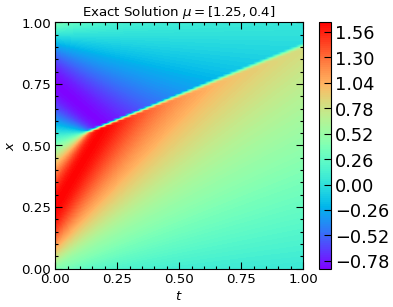

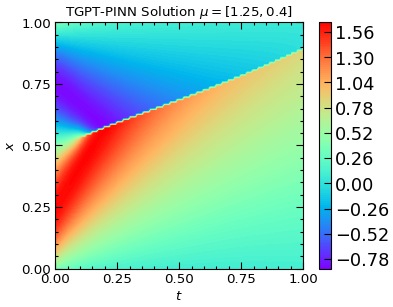

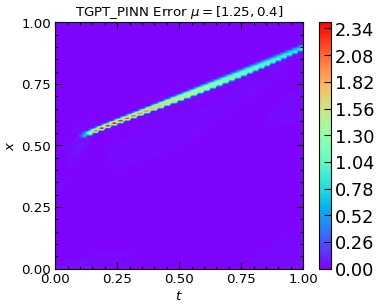

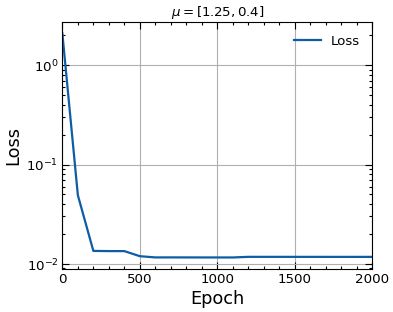

GPT-PINN at [1.25 0.4 ] with the Loss=0.01176570262759924, rMAE = 0.058670725403891295, rRMSE = 0.23776730773953117


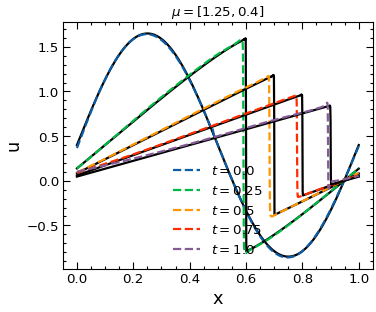

Largest Loss: 0.01176570262759924 at [1.25 0.4 ]
Largest L1: 0.058670725403891295 at [1.25 0.4 ]
Largest L2: 0.23776730773953117 at [1.25 0.4 ]
Loss:[0.000436964794062078, 0.0023195038083940744, 0.0012303882976993918, 0.01176570262759924]
L1:[0.021168762332008383, 0.03817356764945006, 0.029513848362637277, 0.058670725403891295]
L2:[0.10896744863149853, 0.16893171364695364, 0.1698312301107903, 0.23776730773953117]


In [9]:
i=0
nu_pinn_train   =1.0    
lr_gpt          = 0.005
epochs_gpt      = 2000
tol_gpt         = 1e-5
############################ VGPT-PINN Training ############################
layers_gpt = np.array([2, i+1, 1])
c_initial  = torch.full((1,i+1), 1/(i+1))
nu_loss = []
L1_err  = []
L2_err  = []
Cor_err =  []

gpt_train_time_1 = time.perf_counter()
for nu in nu_training:
    IC_u_test = initial_u(nu,IC_x_test)
    God_sol=solve_ivp(burgersDdt_godunov, t_span=(0, Tf), y0=IC_u_test.cpu(), t_eval=IC_t_test)
    Exact_y0 = torch.from_numpy(God_sol.y.T.reshape(xt_test.shape[0],1)).to(device)

    IC_data = create_IC_data(nu, Xi, Xf, Ti, Tf, IC_pts, IC_simple)
    IC_xt     = IC_data[0].to(device)
    IC_u      = IC_data[1].to(device)

    #print((P_list[0]).linears[0].bias)
    GPT_PINN = GPT(nu, layers_gpt, P_list[0:i+1], c_initial,xt_resid, f_hat, Exact_y0, xt_test, IC_xt, IC_u,  BC1, BC2,xt_RHL,xt_RHR,xt_RHt,xt_RHtL,Nx_train,Nt_train,dt).to(device)

    gpt_losses = gpt_train(GPT_PINN, nu, xt_resid, f_hat, Exact_y0, xt_test, IC_xt, IC_u, BC1, BC2, epochs_gpt, lr_gpt, tol_gpt)

    nu_loss.append(gpt_losses[0].item())
    L1_err.append(gpt_losses[3][-1])
    L2_err.append(gpt_losses[4][-1])


    Burgers_plot(xt_test, Exact_y0, Nx_test,Nt_test,title=fr"Exact Solution $\mu=[{nu[0]},{nu[1]}]$")
    Burgers_plot(xt_test, GPT_PINN.forward(xt_test), Nx_test,Nt_test,title=fr"TGPT-PINN Solution $\mu=[{nu[0]},{nu[1]}]$")
    Burgers_plot(xt_test, abs(GPT_PINN.forward(xt_test)-Exact_y0), Nx_test,Nt_test,title=fr"TGPT_PINN Error $\mu=[{nu[0]},{nu[1]}]$")

    plt.figure(dpi=80, figsize=(5,4))    
    plt.plot(gpt_losses[1], gpt_losses[2], label="Loss")
    #plt.plot(gpt_losses[1], gpt_losses[3], label="L1 error")
    #plt.plot(gpt_losses[1], gpt_losses[4], label="L2 error")
    #plt.plot(gpt_losses[1], gpt_losses[5], label="Loss_implict")
    #plt.plot(gpt_losses[1], gpt_losses[8], label="Loss_Res")
    #plt.plot(gpt_losses[1], gpt_losses[6], label="Loss_IC")
    #plt.plot(gpt_losses[1], gpt_losses[7], label="Loss_BC")

    plt.xlabel("Epoch",     fontsize=16)
    plt.ylabel("Loss", fontsize=16)

    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    
    plt.grid(True)
    plt.xlim(0,max(gpt_losses[1]))
    plt.yscale('log')
    plt.title(fr"$\mu=[{nu[0]},{nu[1]}]$", fontsize=12)
    plt.legend(fontsize = 12)#
    plt.show()

    #err =exact_u_err(Exact_y0,GPT_PINN(xt_test),xt_test,nu)[1]
    #Cor_err.append(err.item())
    #print(f"VGPT-PINN at {nu} with the Loss={gpt_losses[0].item()}, rMAE = {gpt_losses[3][-1]}, rRMSE = {gpt_losses[4][-1]} and Cor error = {err.item()}")
    print(f"VGPT-PINN at {nu} with the Loss={gpt_losses[0].item()}, rMAE = {gpt_losses[3][-1]}, rRMSE = {gpt_losses[4][-1]}")

    IC_u_test0 = initial_u(nu,IC_x_test0)
    God_sol0=solve_ivp(burgersDdt_godunov, t_span=(0, Tf), y0=IC_u_test0.cpu(), t_eval=IC_t_test0)
    Exact_y0 = torch.from_numpy(God_sol0.y.T.reshape(xt_test0.shape[0],1)).to(device)  
    PINN_y0 = GPT_PINN.forward(xt_test0)
    plt.figure(dpi=80, figsize=(5,4))#dpi=150, figsize=(10,8)
    for ind in range(1, Nt_test0+1,500):
        plt.plot(xt_test0[0:Nx_test0,0].detach().cpu(),Exact_y0[(ind-1)*Nx_test0:ind*Nx_test0,0].detach().cpu(),'k')
        #plt.scatter(xt_test[0:Nx_test,0].detach().cpu(),PINN(xt_test)[(ind-1)*Nx_test:ind*Nx_test,0].detach().cpu(),s=20,label=fr"$t={round((ind-1)*(Tf-Ti)/(Nt_test-1),3)}$")
        plt.plot(xt_test0[0:Nx_test0,0].detach().cpu(),PINN_y0[(ind-1)*Nx_test0:ind*Nx_test0,0].detach().cpu(),'--',label=fr"$t={round((ind-1)*(Tf-Ti)/(Nt_test0-1),3)}$")
    plt.xlabel("x",     fontsize=16)
    plt.ylabel("u", fontsize=16)

    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.title(fr"$\mu=[{nu[0]},{nu[1]}]$", fontsize=12)
    plt.legend(fontsize = 12)#
    plt.show()

        
print(f"Largest Loss: {max(nu_loss)} at {nu_training[nu_loss.index(max(nu_loss))]}")
print(f"Largest L1: {max(L1_err)} at {nu_training[L1_err.index(max(L1_err))]}")
print(f"Largest L2: {max(L2_err)} at {nu_training[L2_err.index(max(L2_err))]}") 

print(f"Loss:{nu_loss}")
print(f"L1:{L1_err}")
print(f"L2:{L2_err}")

[1.25 0.4 ] stopped at epoch: 0 | gpt_loss: 2.0837979316711426,rMAE: [0.7287366685226848], rRMSE:[0.986358306419847], 0.17441034317016602, 0.19093875586986542, 9.566160308338567e-09, 1.2101540472833627e-12
[1.25 0.4 ] stopped at epoch: 500 | gpt_loss: 0.010776853188872337,rMAE: 0.04504635143347287, rRMSE:0.19227599544070034, 0.0032368337269872427, 0.00011652994726318866, 0.0004969383589923382, 0.00014053368067834526
[1.25 0.4 ] stopped at epoch: 1000 | gpt_loss: 0.013226315379142761,rMAE: 0.03950654153534081, rRMSE:0.10382376394303557, 0.005114988423883915, 0.00019993020396213979, 0.0005680574104189873, 4.314504622016102e-05
[1.25 0.4 ] stopped at epoch: 1500 | gpt_loss: 0.010551420040428638,rMAE: 0.048125737885713435, rRMSE:0.20845962893878123, 0.002922552637755871, 0.00014628014469053596, 0.0005085762240923941, 0.00010803032637340948
[1.25 0.4 ] stopped at epoch: 2000 | gpt_loss: 0.011195696890354156,rMAE: 0.03527988107612165, rRMSE:0.13288300453226723, 0.004209915641695261, 0.000228

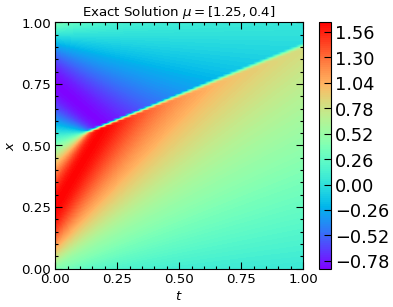

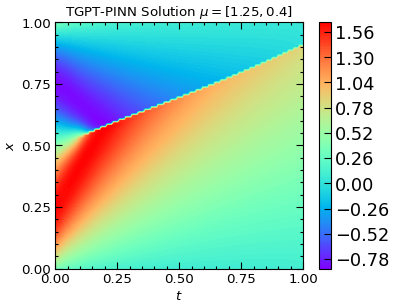

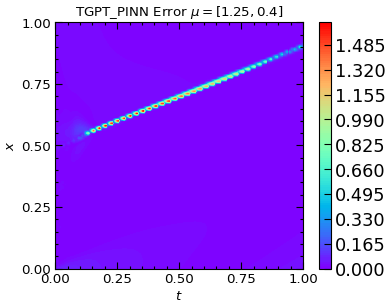

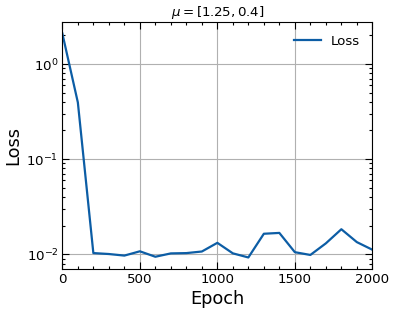

GPT-PINN at [1.25 0.4 ] with the Loss=0.011195696890354156, rMAE = 0.03527988107612165, rRMSE = 0.13288300453226723


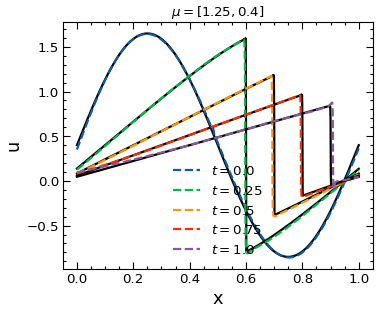

In [15]:
IC_u_test = initial_u(nu,IC_x_test)
God_sol=solve_ivp(burgersDdt_godunov, t_span=(0, Tf), y0=IC_u_test.cpu(), t_eval=IC_t_test)
Exact_y0 = torch.from_numpy(God_sol.y.T.reshape(xt_test.shape[0],1)).to(device)

IC_data = create_IC_data(nu, Xi, Xf, Ti, Tf, IC_pts, IC_simple)
IC_xt     = IC_data[0].to(device)
IC_u      = IC_data[1].to(device)

#print((P_list[0]).linears[0].bias)
GPT_PINN = GPT(nu, layers_gpt, P_list[0:i+1], c_initial,xt_resid, f_hat, Exact_y0, xt_test, IC_xt, IC_u,  BC1, BC2,xt_RHL,xt_RHR,xt_RHt,xt_RHtL,Nx_train,Nt_train,dt).to(device)

gpt_losses = gpt_train(GPT_PINN, nu, xt_resid, f_hat, Exact_y0, xt_test, IC_xt, IC_u, BC1, BC2, epochs_gpt, 10*lr_gpt, tol_gpt)

nu_loss.append(gpt_losses[0].item())
L1_err.append(gpt_losses[3][-1])
L2_err.append(gpt_losses[4][-1])


Burgers_plot(xt_test, Exact_y0, Nx_test,Nt_test,title=fr"Exact Solution $\mu=[{nu[0]},{nu[1]}]$")
Burgers_plot(xt_test, GPT_PINN.forward(xt_test), Nx_test,Nt_test,title=fr"TGPT-PINN Solution $\mu=[{nu[0]},{nu[1]}]$")
Burgers_plot(xt_test, abs(GPT_PINN.forward(xt_test)-Exact_y0), Nx_test,Nt_test,title=fr"TGPT_PINN Error $\mu=[{nu[0]},{nu[1]}]$")

plt.figure(dpi=80, figsize=(5,4))    
plt.plot(gpt_losses[1], gpt_losses[2], label="Loss")
#plt.plot(gpt_losses[1], gpt_losses[3], label="L1 error")
#plt.plot(gpt_losses[1], gpt_losses[4], label="L2 error")
#plt.plot(gpt_losses[1], gpt_losses[5], label="Loss_implict")
#plt.plot(gpt_losses[1], gpt_losses[8], label="Loss_Res")
#plt.plot(gpt_losses[1], gpt_losses[6], label="Loss_IC")
#plt.plot(gpt_losses[1], gpt_losses[7], label="Loss_BC")

plt.xlabel("Epoch",     fontsize=16)
plt.ylabel("Loss", fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)

plt.grid(True)
plt.xlim(0,max(gpt_losses[1]))
plt.yscale('log')
plt.title(fr"$\mu=[{nu[0]},{nu[1]}]$", fontsize=12)
plt.legend(fontsize = 12)#
plt.show()

#err =exact_u_err(Exact_y0,GPT_PINN(xt_test),xt_test,nu)[1]
#Cor_err.append(err.item())
#print(f"GPT-PINN at {nu} with the Loss={gpt_losses[0].item()}, rMAE = {gpt_losses[3][-1]}, rRMSE = {gpt_losses[4][-1]} and Cor error = {err.item()}")
print(f"GPT-PINN at {nu} with the Loss={gpt_losses[0].item()}, rMAE = {gpt_losses[3][-1]}, rRMSE = {gpt_losses[4][-1]}")

IC_u_test0 = initial_u(nu,IC_x_test0)
God_sol0=solve_ivp(burgersDdt_godunov, t_span=(0, Tf), y0=IC_u_test0.cpu(), t_eval=IC_t_test0)
Exact_y0 = torch.from_numpy(God_sol0.y.T.reshape(xt_test0.shape[0],1)).to(device)  
PINN_y0 = GPT_PINN.forward(xt_test0)
plt.figure(dpi=80, figsize=(5,4))#dpi=150, figsize=(10,8)
for ind in range(1, Nt_test0+1,500):
    plt.plot(xt_test0[0:Nx_test0,0].detach().cpu(),Exact_y0[(ind-1)*Nx_test0:ind*Nx_test0,0].detach().cpu(),'k')
    #plt.scatter(xt_test[0:Nx_test,0].detach().cpu(),PINN(xt_test)[(ind-1)*Nx_test:ind*Nx_test,0].detach().cpu(),s=20,label=fr"$t={round((ind-1)*(Tf-Ti)/(Nt_test-1),3)}$")
    plt.plot(xt_test0[0:Nx_test0,0].detach().cpu(),PINN_y0[(ind-1)*Nx_test0:ind*Nx_test0,0].detach().cpu(),'--',label=fr"$t={round((ind-1)*(Tf-Ti)/(Nt_test0-1),3)}$")
plt.xlabel("x",     fontsize=16)
plt.ylabel("u", fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.title(fr"$\mu=[{nu[0]},{nu[1]}]$", fontsize=12)
plt.legend(fontsize = 12)#
plt.show()